In [1]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

## Read Data

In [84]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10','WSLS_1']

numSubjects = len(subjectNames)

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2,3])

species = ['monkeys','humans','humans2','agent']
speciesName = ['Monkeys','Human set 1', 'Human set 2','WSLS Agent']
fNameSuffix = ['Monkey','Human','Human2', 'Agent']

stateNames = ['Persist','Preferred','Random','Avoid']

speciesColors = ['#fb8072', '#8dd3c7','#3288bd','#000000']

######################################
trainDat = dict()
testDat = dict()

for s, suff in zip(species, fNameSuffix):
    with open("analysis/"+s+".npz", "rb") as f:
        npzfile = np.load(f)
        trainDat[s] = npzfile['trainLL'+suff]
        testDat[s] = npzfile['testLL'+suff]
        # print(trainDat[s].shape)

trainDat_objPred = dict()
testDat_objPred = dict()

for s, suff in zip(species[:2], fNameSuffix[:2]):
    with open("analysis/"+s+"_objPred.npz", "rb") as f:
        npzfile = np.load(f)
        trainDat_objPred[s] = npzfile['trainLL'+suff]
        testDat_objPred[s] = npzfile['testLL'+suff]
        # print(trainDat[s].shape)


analysis = []
data = []
data0 = []

for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)

with open('data/WSLS_feat.pickle','rb') as f:
    [featData] = pickle.load(f)

with open('analysis/objPredSummary.pickle', 'rb') as f:
    [probabilityPredM, probabilityPredH, sigM, sigH] = pickle.load(f)

### Plot helper

In [85]:

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x


## SSM cross-validation performance for each subject, each species (dataset)

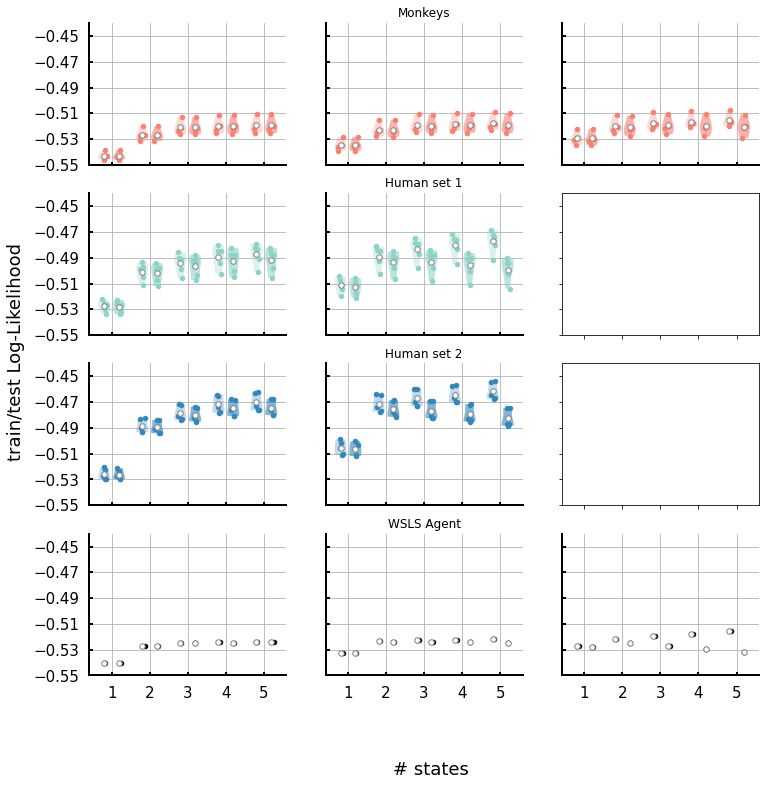

In [88]:
vpWidth = 0.35

fig, ax = plt.subplots(ncols=3,nrows=4,sharex=True,sharey=True,figsize=(3*4,3*4))

fig.text(0.52, 0.01, '# states', ha='center', size=18)
fig.text(0.03, 0.5, 'train/test Log-Likelihood', va='center', rotation='vertical', size=18)

for spInd in range(4): # Monkeys and 2 human datasets

    for lag in range(trainDat[species[spInd]].shape[0]): # Lag used for history
        for k in range(5): # No. states
            for pType in range(2): # train / test
                if pType == 0:
                    data1 = trainDat[species[spInd]][lag,:,k]
                else:
                    data1 = testDat[species[spInd]][lag,:,k]
                x1 = k+1-vpWidth/1.8+(2*pType*vpWidth/1.8)
                # Violin
                vp1 = ax[spInd, lag].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
                for pc in vp1['bodies']:
                    pc.set_facecolor(speciesColors[spInd])
                    pc.set_alpha(0.3+0.3*pType)

                # Points
                x = npr.rand(trainDat[species[spInd]].shape[1]) * (vpWidth) * (0.2)
                pm = getPM(x.shape[0])
                x = np.multiply(x,pm) + x1
                ax[spInd, lag].scatter(x,data1,s=20,color=speciesColors[spInd])

                ax[spInd, lag].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

        # Prettify
        ax[spInd, lag].set_ylim([-0.55,-0.44])

        ax[spInd, lag].set_axisbelow(True)
        ax[spInd, lag].tick_params(axis='both',labelsize= 15,direction='in',pad=10)

        ax[spInd, lag].set_xticks(np.arange(5)+1)
        ax[spInd, lag].set_yticks(np.arange(-0.55,-0.44, 0.02))
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax[spInd, lag].spines[axis].set_linewidth(2)

        ax[spInd, lag].spines['right'].set_visible(False)
        ax[spInd, lag].spines['top'].set_visible(False)

        # increase tick width
        ax[spInd, lag].tick_params(width=2)
        ax[spInd, lag].grid(which='major', axis='both')


    ax[spInd, 1].set_title(speciesName[spInd])
    
# plt.savefig('figures/fig2/fitStats.eps', format='eps')

## Example states for one subject of each species

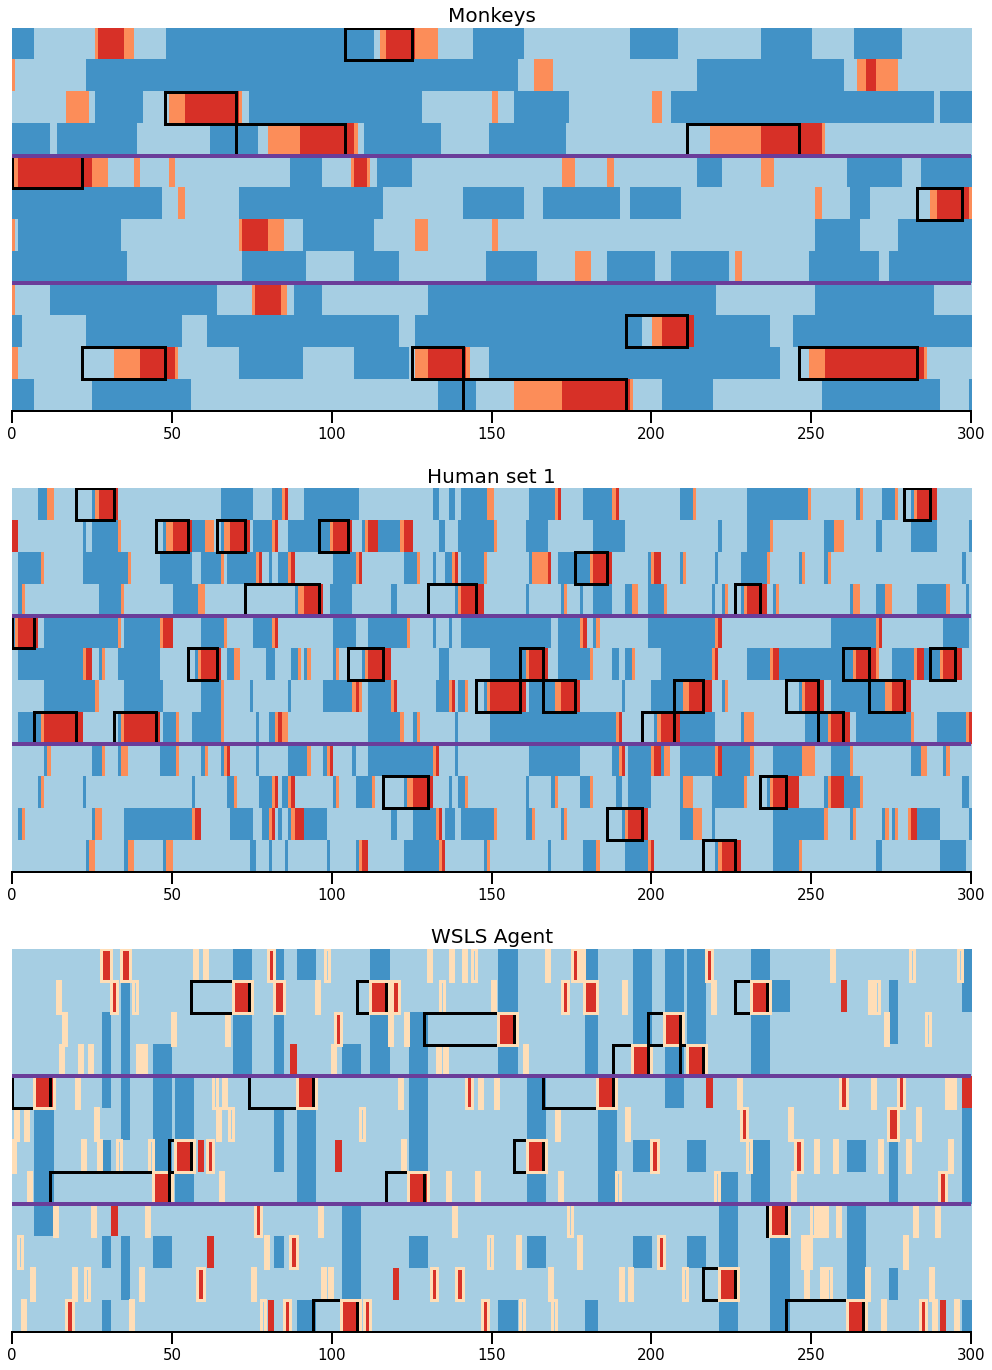

In [90]:

# define color map for states
color_map = {0: np.array([215,48,39]),
             1: np.array([252,141,89]),
             2: np.array([166,206,227]), 
             3: np.array([66,146,198])} 

fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(4*2*5,4*2*3))

for spInd in range(3): # Monkeys, first human dataset and WSLS Agent
    ####### Plot States #######
    if spInd == 0: #monkey
        sp_dInd = 0
        dd = data0[sp_dInd]['superBlocksData']['viterbi'][4][:,:300]
    elif spInd == 1: #human dataset 1
        sp_dInd = 4
        dd = data0[sp_dInd]['superBlocksData']['viterbi'][4][:,:]
    else: # WSLS Agent
        color_map = {0: np.array([215,48,39]),
                     1: np.array([166,206,227]), #224,243,248
                    2: np.array([66,146,198])} #116,173,209
        sp_dInd = 14
        dd = data0[sp_dInd]['superBlocksData']['viterbi'][4][:,:300]


    # make a 3d numpy array that has a color channel dimension
    data_3d = np.ndarray(shape=(dd.shape[0], dd.shape[1], 3), dtype=int)
    for i in range(0, dd.shape[0]):
        for j in range(0, dd.shape[1]):
            data_3d[i][j] = color_map[dd[i][j]]

    ax[spInd].imshow(data_3d,extent=[0,300,0,12], aspect=10)

    ####### Plot Indicator boxes #######
    cRule = data0[sp_dInd]['superBlocksData']['rule'][4][0]
    st = 0
    ln = 1
    if spInd == 2: # WSLS Agent, second box type
        fd = featData[4][:300]
        cRule2 = fd[0]
        st2 = 0
        ln2 = 1
    for i in range(1, min(300, data0[sp_dInd]['superBlocksData']['viterbi'][4].shape[1])):
        if cRule == data0[sp_dInd]['superBlocksData']['rule'][4][i]:
            ln += 1
        else:
            rect = patches.Rectangle((st, 11-cRule), ln, 1, linewidth=3, edgecolor='k', facecolor='none')
            ax[spInd].add_patch(rect)
            st = i
            ln = 1
            cRule = data0[sp_dInd]['superBlocksData']['rule'][4][i]

        if spInd == 2: # WSLS Agent
            if cRule2 == fd[i]: #data0[9]['superBlocksData']['rule'][4][i]:
                ln2 += 1
            else:
                rect = patches.Rectangle((st2, 11-cRule2), ln2, 1, linewidth=3, edgecolor='#ffdeb7', facecolor='none')
                ax[spInd].add_patch(rect)
                st2 = i
                ln2 = 1
                cRule2 = fd[i]

            
    # Prettify
    ax[spInd].plot([0, 300],[8,8],linewidth=4,color='#6a3d9a')
    ax[spInd].plot([0, 300],[4,4],linewidth=4,color='#6a3d9a')
    ax[spInd].tick_params(axis='both',direction='out',labelsize= 15, width=2, length=12)
    # ax.tick_params(axis='x',length=5,labelsize=18)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[spInd].spines[axis].set_linewidth(2)

    ax[spInd].spines['left'].set_visible(False)
    ax[spInd].spines['right'].set_visible(False)
    ax[spInd].spines['top'].set_visible(False)

    ax[spInd].set_axisbelow(True)
    # ax.get_xaxis().set_visible(False)
    ax[spInd].get_yaxis().set_visible(False)
    # plt.savefig('exampleMonkeyStates.eps', format='eps')
    if spInd < 2:
        ax[spInd].set_title(speciesName[spInd],fontsize=20)
    else:
        ax[spInd].set_title(speciesName[3],fontsize=20)
        
# plt.savefig('figures/fig2/exampleStates.eps', format='eps')

## Distribution of posterior probabilities for most-likely state selected

Text(0.5, 0, 'State posterior probability')

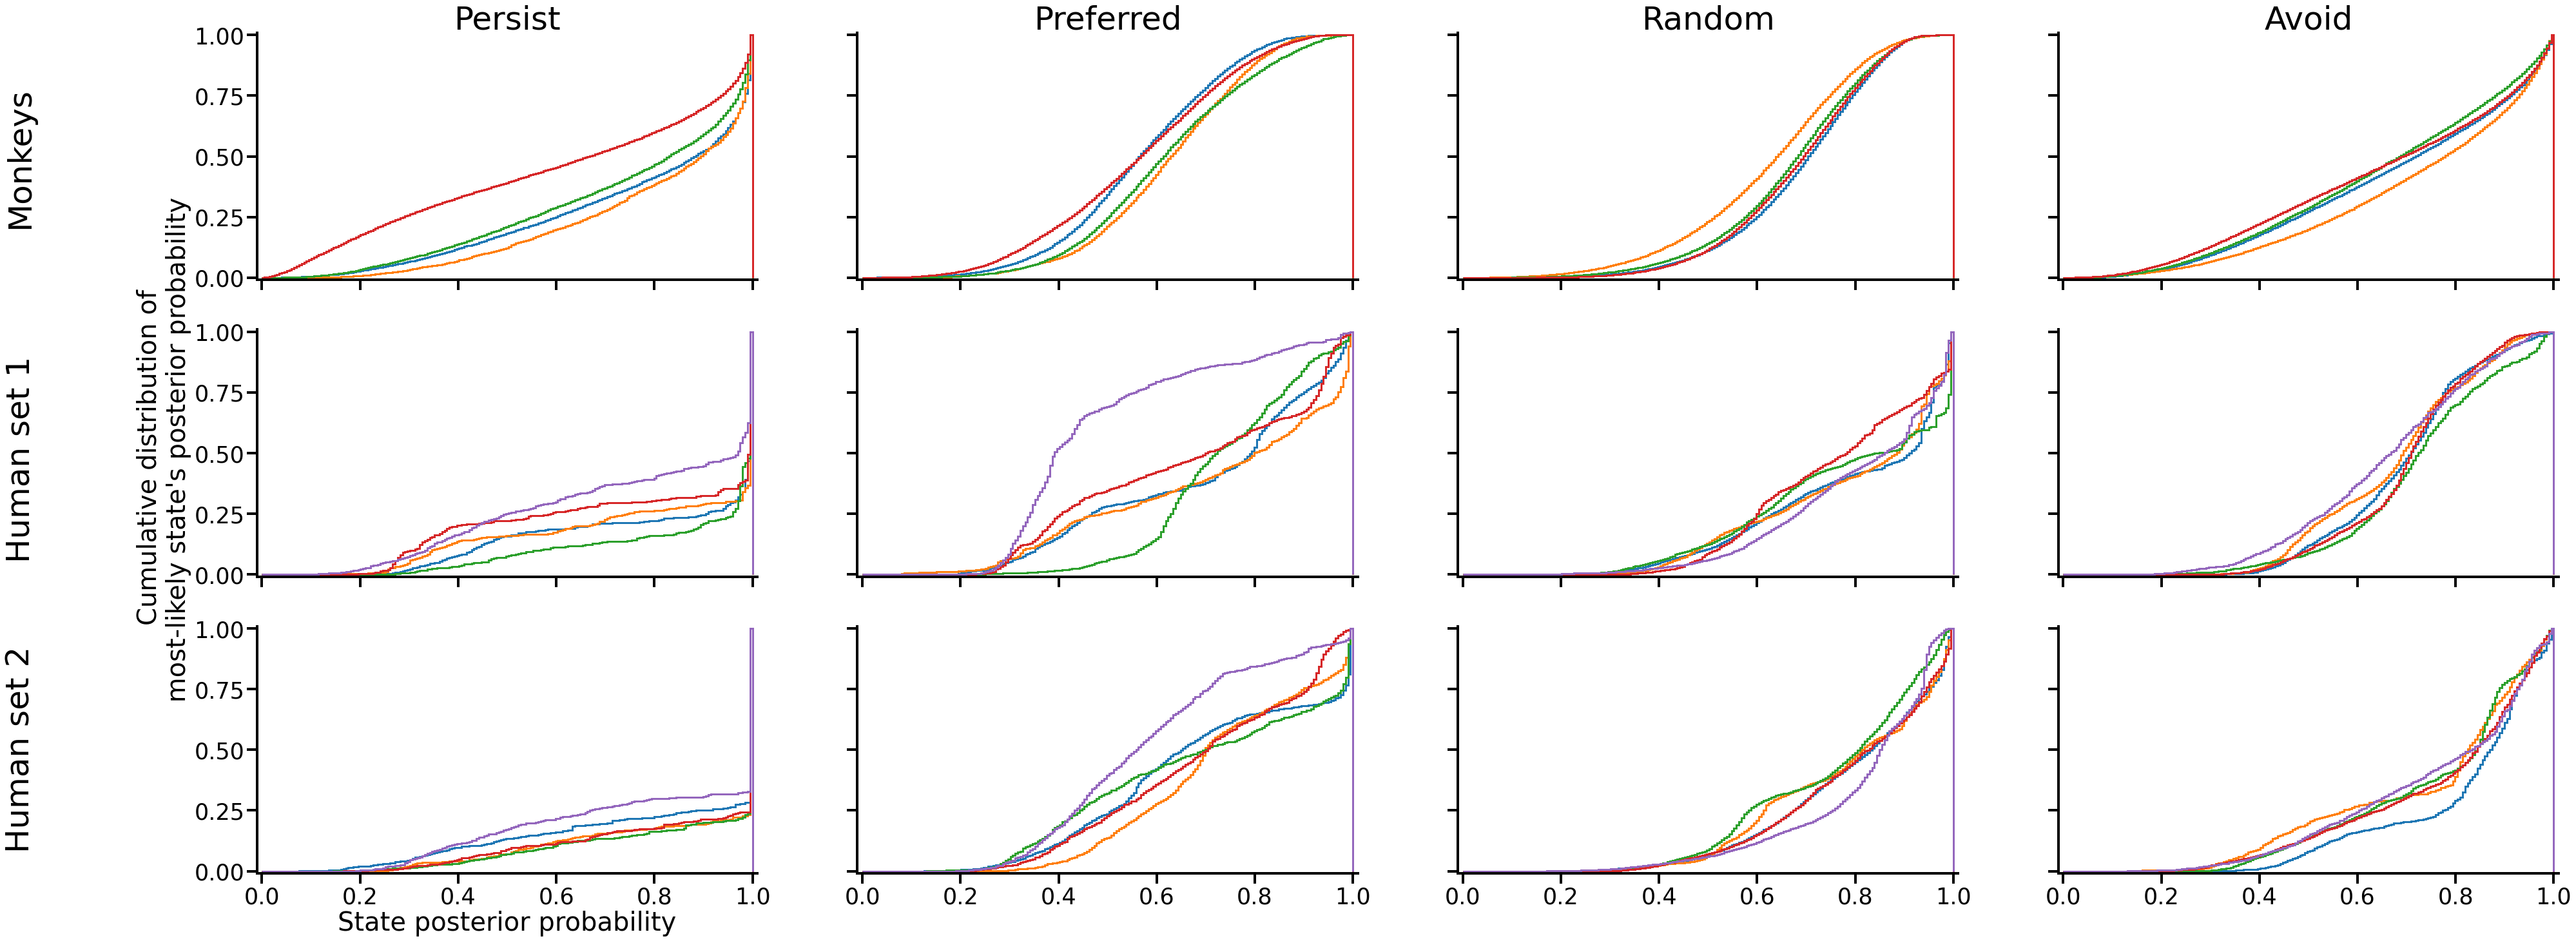

In [92]:
fig, ax = plt.subplots(ncols=4,nrows=3,figsize=(4*2*8,4*2*3),sharex=True, sharey = True)

binsX = np.linspace(0, 1, 200)
for i in range(4): # states
    for j in range(3): # species
        krng = np.where(speciesList==j)[0]
        for k in krng: # individual subjects
                X = []
                for l in range(len(data0[k]['superBlocksData']['posterior'])): # rule blocks
                    # Collect posteriors for selected most-likely states
                    for f in range(12): # individual features
                        pInds = np.nonzero(data0[k]['superBlocksData']['viterbi'][l][f,:] == i)
                        dd = np.squeeze(data0[k]['superBlocksData']['posterior'][l][f,pInds,i])
                        if dd.size > 0 and dd.ndim > 0:
                            X.append(dd)
                Y = np.concatenate(X, axis = 0)
                # Compute histogram and plot
                ax[j][i].hist(Y, binsX, weights=np.ones_like(Y)/Y.size, cumulative=True, histtype='step',linewidth=3)

                ax[j][i].tick_params(axis='both',labelsize= 35,direction='out',width=4, length=16)
                # change all spines
                for axis in ['top','bottom','left','right']:
                    ax[j][i].spines[axis].set_linewidth(4)

                ax[j][i].spines['right'].set_visible(False)
                ax[j][i].spines['top'].set_visible(False)
                ax[j][i].set_xlim([-0.01,1.01])
                ax[j][i].set_ylim([-0.01,1.01])

                ax[j][i].set_axisbelow(True)
        
        if j == 0:
            ax[j][i].set_title(stateNames[i],fontsize=50)
                
                
fig.text(0.04, 0.71, speciesName[0], rotation='vertical',fontsize=50)
fig.text(0.04, 0.41, speciesName[1], rotation='vertical',fontsize=50)
fig.text(0.04, 0.15, speciesName[2], rotation='vertical',fontsize=50)

ax[1][0].set_ylabel('Cumulative distribution of \n most-likely state\'s posterior probability',fontsize=40)
ax[2][0].set_xlabel('State posterior probability',fontsize=40)

# plt.savefig('figures/fig2/posteriorProbDistr.eps', format='eps')

## WSLS Agent's choice probability per-state

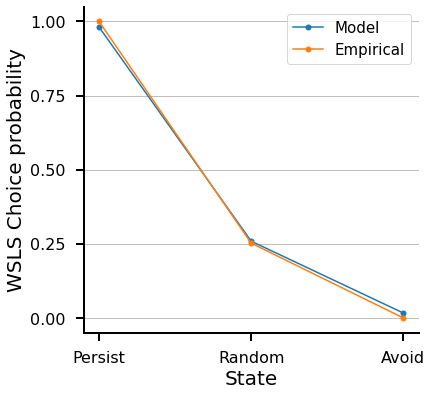

In [47]:
# Collect data
pc_S_mdl = analysis[np.where(speciesList==3)[0][0]]['choiceStats']['pc_S_mdl']
pc_S_emp = analysis[np.where(speciesList==3)[0][0]]['choiceStats']['pc_S_emp']

fig, ax = plt.subplots(figsize=(6,6),nrows=1,ncols=1)

# Plot values
ax.plot(pc_S_mdl,marker='.', markersize=10,label='Model')
ax.plot(pc_S_emp,marker='.', markersize=10,label='Empirical')


ax.set_xticks([0,1,2])
ax.set_xticklabels(stateNames[0,2,3])
ax.tick_params(axis='x',labelsize= 16,direction='in',pad=10)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.tick_params(axis='y',labelsize= 16,direction='in',pad=10)
ax.legend(fontsize=15)

ax.set_ylabel('WSLS Choice probability',fontsize=20)
ax.set_xlabel('State',fontsize=20)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# increase tick width
ax.tick_params(width=2)
ax.tick_params(direction='out',length=8)

ax.grid(which='major', axis='y')
# plt.savefig('figures/fig2/WSLS_ChoiceProb.eps', format='eps')

## Object choice probability

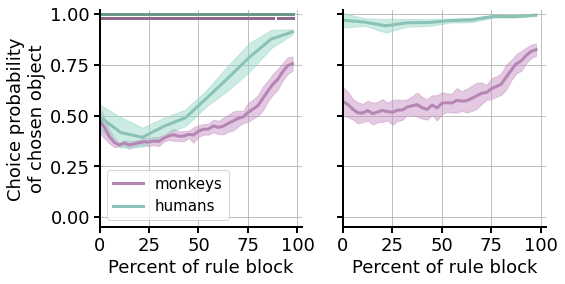

In [55]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(4*2,4), sharey=True)
speciesColor = np.array([[201,148,199],[153,216,201]])/255

for pType in range(2): # type of feature choice statistic used
    for spInd in range(2): # species type
        if spInd == 0: # Monkeys
            probabilityPredS = probabilityPredM[:,:,pType]
            xSpecies = np.arange(40)
            sigS = sigM
        else: # Humans
            probabilityPredS = probabilityPredH[:,:,pType]
            xSpecies = np.arange(0,40,4.333333)
            sigS = sigH

        # plot mean probabilities (across subojects)
        meanSpecies = np.mean(probabilityPredS,axis=1)
        stdSpecies = np.std(probabilityPredS,axis=1)

        # plot std-devs
        loSpecies = meanSpecies-stdSpecies
        hiSpecies = meanSpecies+stdSpecies
        ax[pType].plot(xSpecies,meanSpecies,linewidth=3,color=speciesColor[spInd]*0.9, label=species[spInd])
        ax[pType].fill_between(xSpecies,loSpecies,hiSpecies,color=speciesColor[spInd],alpha=0.5)

        # Plot significance test results
        if pType == 0:
            ic = -1
            start = -1
            for i in xSpecies:
                ic = ic + 1
                if sigS[ic] < 0.05:
                    if start == -1:
                        start = i
                else:
                    if start > -1:
                        ax[pType].plot([start, i],[0.98+0.02*spInd,0.98+0.02*spInd],'-',linewidth=3,color=speciesColor[spInd]*0.7)
                        start = -1

                if start > -1:
                    ax[pType].plot([start, i],[0.98+0.02*spInd,0.98+0.02*spInd],'-',linewidth=3,color=speciesColor[spInd]*0.7)

    #######################

    # Prettify
    ax[pType].set_xticks([0,10,20,30,40])
    ax[pType].set_yticks([0,0.25,0.5,0.75,1])
    ax[pType].set_xticklabels([0,25,50,75,100])
    ax[pType].set_ylim([-0.05,1.02])

    ax[pType].set_xlim([0,41])
    ax[pType].set_xlabel('Percent of rule block',fontsize=18)

    if pType == 0:
        ax[pType].set_ylabel('Choice probability\nof chosen object',fontsize=18)
        ax[pType].legend(fontsize=15)
    
    ax[pType].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[pType].spines[axis].set_linewidth(2)

    ax[pType].spines['right'].set_visible(False)
    ax[pType].spines['top'].set_visible(False)

    ax[pType].set_axisbelow(True)
    ax[pType].grid(which='major', axis='both')
    

# plt.savefig('figures/fig2/objPredProb.eps', format='eps')


## Object prediction log-likelihood (object prediction model)

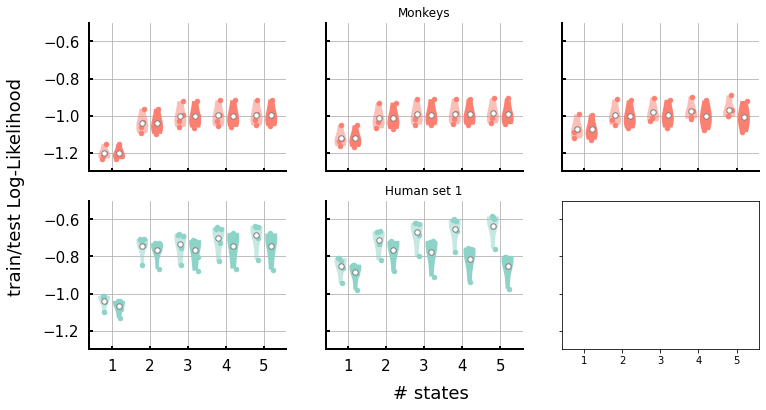

In [83]:
vpWidth = 0.35

fig, ax = plt.subplots(ncols=3,nrows=2,sharex=True,sharey=True,figsize=(3*4,3*2))

fig.text(0.52, 0.01, '# states', ha='center', size=18)
fig.text(0.03, 0.5, 'train/test Log-Likelihood', va='center', rotation='vertical', size=18)

for spInd in range(2): # species type

    for lag in range(trainDat_objPred[species[spInd]].shape[0]): # Lag used for history
        for k in range(5): # No. states
            for pType in range(2): # # train / test
                if pType == 0:
                    data1 = trainDat_objPred[species[spInd]][lag,:,k]
                else:
                    data1 = testDat_objPred[species[spInd]][lag,:,k]

                # Violin
                x1 = k+1-vpWidth/1.8+(2*pType*vpWidth/1.8)
                vp1 = ax[spInd, lag].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
                for pc in vp1['bodies']:
                    pc.set_facecolor(speciesColors[spInd])
                    pc.set_alpha(0.5+0.5*pType)

                # Points
                x = npr.rand(trainDat_objPred[species[spInd]].shape[1]) * (vpWidth) * (0.2)
                pm = getPM(x.shape[0])
                x = np.multiply(x,pm) + x1
                ax[spInd, lag].scatter(x,data1,s=20,color=speciesColors[spInd])

                ax[spInd, lag].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

        # Prettify
        ax[spInd, lag].set_ylim([-1.3,-0.5])

        ax[spInd, lag].set_axisbelow(True)
        ax[spInd, lag].tick_params(axis='both',labelsize= 15,direction='in',pad=10)

        ax[spInd, lag].set_xticks(np.arange(5)+1)
        ax[spInd, lag].set_yticks(np.arange(-1.2,-0.5, 0.2))
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax[spInd, lag].spines[axis].set_linewidth(2)

        ax[spInd, lag].spines['right'].set_visible(False)
        ax[spInd, lag].spines['top'].set_visible(False)

        # increase tick width
        ax[spInd, lag].tick_params(width=2)

        ax[spInd, lag].grid(which='major', axis='both')

    ax[spInd, 1].set_title(speciesName[spInd])
    
# plt.savefig('figures/fig2/objectFitStats.eps', format='eps')